In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
#import scienceplots
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import tensorflow.keras.callbacks
from keras import backend as K
from keras.regularizers import l2
import albumentations as A

In [3]:
train_transforms = A.Compose([
    A.VerticalFlip(),
    A.HorizontalFlip(),
    A.Rotate(limit=30),
    A.GaussNoise(var_limit=0.015)
])

val_transforms = A.Compose([
    A.NoOp()
])

In [4]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(9, 9))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.title(' '.join(name.split('_')).title())

        if 'mask' in name:
            if image.ndim == 3 and image.shape[-1] > 1:
                image = np.argmax(image, axis=-1)
                
        plt.imshow(image, cmap = 'bone')
    plt.show()

In [5]:
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    x = np.repeat(x, 3, axis=-1)
    return x

def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = x.astype(np.int32)
    return x

# todo: заменить train test split на tf.keras.utils.split_dataset при бОльшем размере датасета

In [6]:
def load_data(x_path, y_path):
    images = os.listdir(x_path)
    masks = os.listdir(y_path)
    
    X = [os.path.join(x_path, image) for image in images]
    y = [os.path.join(y_path, mask) for mask in masks]
    
    train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)
    train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.25, random_state=42)

    return train_x, train_y, val_x, val_y, test_x, test_y

In [7]:
def tf_dataset(x, y, transformations, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=len(x))
    dataset = dataset.map(lambda x, y: preprocess(x, y, transformations))
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

def preprocess(x, y, transformations):

    def aug(x,y):
        x = x.decode()
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        augmented = transformations(image=image,mask=mask)
        aug_img=augmented['image']
        aug_mask = augmented['mask']
        return aug_img, aug_mask
    
    image, mask = tf.numpy_function(aug, [x,y], [tf.float32, tf.int32])

    mask = tf.one_hot(mask, 3, dtype = tf.int32) #обязательно так как сегментация мультиклассовая

    image.set_shape([512,512,3])
    mask.set_shape([512,512,3])

    return image, mask

In [8]:
Ncl = 3
w = K.zeros(shape=(Ncl,))

def generalized_dice_coeff(y_true, y_pred):
    y_pred = K.cast(y_pred, 'float32')
    y_true = K.cast(y_true, 'float32')
    w = K.sum(y_true, axis=(0,1,2))
    w = 1.0/(w**2+0.000001)

    numerator = y_true*y_pred
    numerator = w*K.sum(numerator,(0,1,2))
    numerator = K.sum(numerator)

    denominator = y_true+y_pred
    denominator = w*K.sum(denominator,(0,1,2))
    denominator = K.sum(denominator)

    gen_dice_coef = 2*numerator/denominator

    return gen_dice_coef

def generalized_dice_loss(y_true, y_pred):
    return 1 - generalized_dice_coeff(y_true, y_pred)

<!-- Ncl = 3
w = K.zeros(shape=(Ncl,))

def generalized_dice_coeff(y_true, y_pred):
    y_pred = K.cast(y_pred, 'float32')
    y_true = K.cast(y_true, 'float32')
    w = K.sum(y_true, axis=(0,1,2))

    w = 1.0/(w**2+0.000001)
    
    numerator = y_true*y_pred
    print(numerator.shape)
    numerator = w*K.sum(numerator,(0, 1, 2))
    print(numerator, numerator.shape)
    numerator = K.sum(numerator)
    print(numerator, numerator.shape)


    denominator = y_true+y_pred
    denominator = w*K.sum(denominator,(0,1,2))
    denominator = K.sum(denominator)

    gen_dice_coef = 2*numerator/denominator

    return gen_dice_coef

def generalized_dice_loss(y_true, y_pred):
    return 1 - generalized_dice_coeff(y_true, y_pred) -->

In [9]:
# def tversky_coeff(y_true, y_pred, beta):
#     y_pred = K.cast(y_pred, 'float32')
#     y_true = K.cast(y_true, 'float32')
#     w = K.sum(y_true, axis=(0,1,2))

#     w = 1.0/(w**2+0.000001)
#     smooth = 1
#     print(y_true.shape)
#     y_true = K.permute_dimensions(y_true, (3,1,2,0))
#     y_pred = K.permute_dimensions(y_pred, (3,1,2,0))
#     print(y_true.shape)
#     y_true_pos = K.batch_flatten(y_true)
#     y_pred_pos = K.batch_flatten(y_pred)
#     true_pos = w*K.sum(y_true_pos * y_pred_pos, 1)
#     print((y_true_pos * y_true_pos).shape, true_pos)
#     false_neg = K.sum(y_true_pos * (1-y_pred_pos), 1)
#     false_pos = K.sum((1-y_true_pos)*y_pred_pos, 1)

#     denominator = true_pos + beta*false_pos + (1-beta)*false_neg + smooth

#     return K.mean((true_pos + smooth)/(denominator))

# def tversky_loss(y_true, y_pred, beta=0.4):
#     return 1 - tversky_coeff(y_true, y_pred, beta)

In [10]:
# def tversky_coeff(y_true, y_pred, beta):
#     y_pred = K.cast(y_pred, 'float32')
#     y_true = K.cast(y_true, 'float32')
#     smooth = 1

#     y_true = K.permute_dimensions(y_true, (3,1,2,0))
#     y_pred = K.permute_dimensions(y_pred, (3,1,2,0))

#     y_true_pos = K.batch_flatten(y_true)
#     y_pred_pos = K.batch_flatten(y_pred)
#     true_pos = K.sum(y_true_pos * y_pred_pos, 1)
#     false_neg = K.sum(y_true_pos * (1-y_pred_pos), 1)
#     false_pos = K.sum((1-y_true_pos)*y_pred_pos, 1)

#     return K.mean((true_pos + smooth)/(true_pos + beta*false_pos + (1-beta)*false_neg + smooth))

# def tversky_loss(y_true, y_pred, beta=0.4):
#     return 1 - tversky_coeff(y_true, y_pred, beta)

In [11]:
def tversky(y_true, y_pred, axis=(0, 1, 2), alpha=0.6, beta=0.4, smooth=0.0001):
    "Tversky metric"
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.math.reduce_sum(y_true * y_pred, axis=axis) # calculate True Positive
    fn = tf.math.reduce_sum(y_true * (1 - y_pred), axis=axis) # calculate False Negative
    fp = tf.math.reduce_sum((1 - y_true) * y_pred, axis=axis) # calculate False Positive
    tv = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth) # calculate tversky
    tv = tf.math.reduce_mean(tv)
    return tv
def focal_tversky_loss(y_true, y_pred, gamma=1):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

In [12]:
class LossHistory(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

## Гиперпараметры для моделей

In [13]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3
n_classes = 3

LR = 1e-4
epochs = 50

## Формирование датасета и Визуализация

In [27]:
np.random.seed(42)
tf.random.set_seed(42)
batch_size = 2

images_path = r"C:\Users\stepan\ML\datasets\multiclass_semantic_liver-tumor\Train_Ct-Scan"
masks_path = r"C:\Users\stepan\ML\datasets\multiclass_semantic_liver-tumor\Train_Ct-Scan_masks"

train_x, train_y, val_x, val_y, test_x, test_y = load_data(images_path, masks_path)

train_ds = tf_dataset(train_x, train_y, transformations=train_transforms, batch=batch_size)
val_ds = tf_dataset(val_x, val_y, transformations=val_transforms, batch=batch_size)

(2, 512, 512, 3)
0


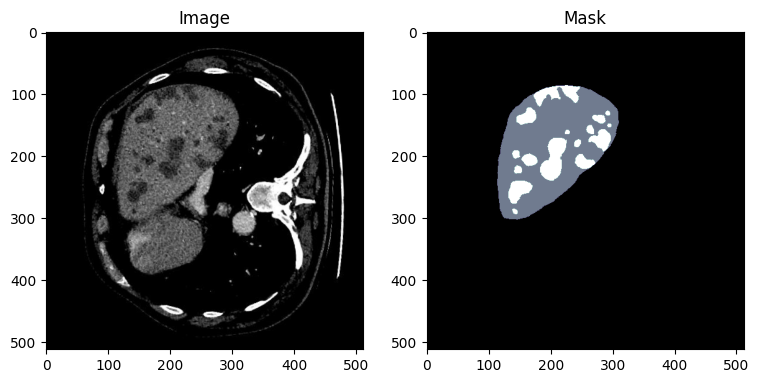

1


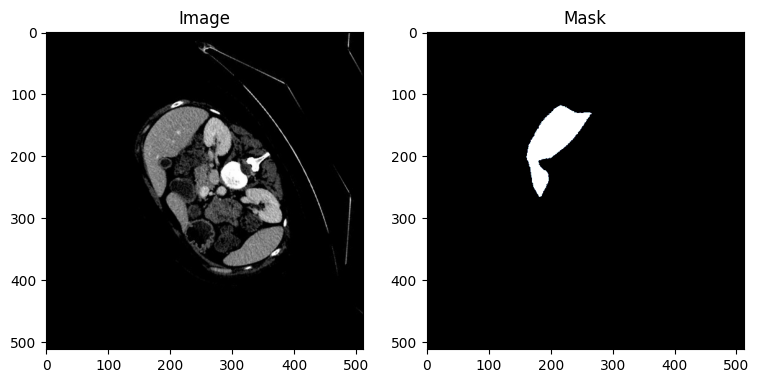

In [15]:
for images, labels in train_ds.take(1): 
    numpy_images = images.numpy()
    numpy_masks = labels.numpy()
    print(numpy_masks.shape)
    for i in range(numpy_images.shape[0]):
        print(i)
        visualize(image = numpy_images[i, ...], mask = numpy_masks[i, ...])

In [16]:
train_steps = len(train_x)//batch_size
valid_steps = len(val_x)//batch_size

In [17]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, concatenate, Conv2DTranspose, Activation, BatchNormalization, Dropout, Lambda


## Модель resunet plus plus 

In [18]:
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from keras.layers import Multiply, Add, GlobalAveragePooling2D, Reshape, Dense

def SE(inputs, ratio=8):
    channel_axis = -1
    num_filters = inputs.shape[channel_axis]
    se_shape = (1, 1, num_filters)

    x = GlobalAveragePooling2D()(inputs)
    x = Reshape(se_shape)(x)
    x = Dense(num_filters // ratio, activation='relu', use_bias=False)(x)
    x = Dense(num_filters, activation='sigmoid', use_bias=False)(x)

    x = Multiply()([inputs, x])
    return x


def stem_block(inputs, num_filters):
    ## Conv 1
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)

    ## Shortcut
    s = Conv2D(num_filters, 1, padding="same")(inputs)

    ## Add
    x = Add()([x, s])
    return x

def resnet_block(inputs, num_filters, strides=1):
    ## SE
    inputs = SE(inputs)

    ## Conv 1
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same", strides=strides)(x)

    ## Conv 2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1)(x)

    ## Shortcut
    s = Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)

    ## Add
    x = Add()([x, s])

    return x

def aspp_block(inputs, num_filters):
    x1 = Conv2D(num_filters, 3, dilation_rate=6, padding="same")(inputs)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, 3, dilation_rate=12, padding="same")(inputs)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, 3, dilation_rate=18, padding="same")(inputs)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(inputs)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, 1, padding="same")(y)

    return y

def attetion_block(x1, x2):
    num_filters = x2.shape[-1]

    x1_conv = BatchNormalization()(x1)
    x1_conv = Activation("relu")(x1_conv)
    x1_conv = Conv2D(num_filters, 3, padding="same")(x1_conv)
    x1_pool = MaxPooling2D((2, 2))(x1_conv)

    x2_conv = BatchNormalization()(x2)
    x2_conv = Activation("relu")(x2_conv)
    x2_conv = Conv2D(num_filters, 3, padding="same")(x2_conv)

    x = Add()([x1_pool, x2_conv])

    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)

    x = Multiply()([x, x2])
    return x

def resunet_pp(n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # encoding
    c1 = stem_block(inputs, 16)
    c2 = resnet_block(c1, 32, strides=2)
    c3 = resnet_block(c2, 64, strides=2)
    c4 = resnet_block(c3, 128, strides=2)

    # bridge
    b1 = aspp_block(c4, 256)

    # decoding
    d1 = attetion_block(c3, b1)
    d1 = UpSampling2D((2, 2))(d1)
    d1 = Concatenate()([d1, c3])
    d1 = resnet_block(d1, 128)

    d2 = attetion_block(c2, d1)
    d2 = UpSampling2D((2, 2))(d2)
    d2 = Concatenate()([d2, c2])
    d2 = resnet_block(d2, 64)

    d3 = attetion_block(c1, d2)
    d3 = UpSampling2D((2, 2))(d3)
    d3 = Concatenate()([d3, c1])
    d3 = resnet_block(d3, 32)

    outputs = aspp_block(d3, 16)
    outputs = Conv2D(n_classes, 1, padding="same")(outputs)
    outputs = Activation("softmax")(outputs)

    model = Model(inputs, outputs, name='RESUNET_pp')
    return model

In [18]:
resunet_pp_model = resunet_pp(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
resunet_pp_model.compile(loss=focal_tversky_loss, optimizer=tf.keras.optimizers.Adam(LR), metrics = [tversky, tf.keras.metrics.OneHotMeanIoU(num_classes=3)])
resunet_pp_model.summary()

Model: "RESUNET_pp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                        

## Обучение resunet_pp

In [19]:
history_class = LossHistory()

callbacks = [
    ModelCheckpoint("resunet_pp_andreydataset_focaltversky_alpha0.6_beta0.4_gamma_1.hdf5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, verbose=1),
    EarlyStopping(monitor="val_loss", mode='min', patience=5, verbose=1,min_delta=0.0001),
    TensorBoard(log_dir='logs_resunet_pp_andreydataset_focaltversky_alpha0.6_beta0.4_gamma_1'),
    history_class
]

resunet_pp_model_history = resunet_pp_model.fit(train_ds,
                    steps_per_epoch=train_steps,validation_data=val_ds,
                    validation_steps=valid_steps,epochs=epochs,
                    callbacks=callbacks,verbose = 1)
resunet_pp_model.save('final_resunet_pp_andreydataset_focaltversky_alpha0.6_beta0.4_gamma_1.hdf5')

resunet_pp_hist_df = pd.DataFrame(resunet_pp_model_history.history)

hist_csv_file = 'history_resunet_pp_andreydataset_focaltversky_alpha0.6_beta0.4_gamma_1.csv'
with open(hist_csv_file, mode='w') as f:
    resunet_pp_hist_df.to_csv(f)

Epoch 1/50
7963/7963 [==============================] - ETA: 0s - loss: 0.3258 - tversky: 0.6742 - one_hot_mean_io_u: 0.6485
Epoch 1: saving model to resunet_pp_andreydataset_focaltversky_alpha0.6_beta0.4_gamma_1.hdf5
7963/7963 [==============================] - 2251s 281ms/step - loss: 0.3258 - tversky: 0.6742 - one_hot_mean_io_u: 0.6485 - val_loss: 0.3002 - val_tversky: 0.6998 - val_one_hot_mean_io_u: 0.7477 - lr: 1.0000e-04
Epoch 2/50
7963/7963 [==============================] - ETA: 0s - loss: 0.2763 - tversky: 0.7236 - one_hot_mean_io_u: 0.7436
Epoch 2: saving model to resunet_pp_andreydataset_focaltversky_alpha0.6_beta0.4_gamma_1.hdf5
7963/7963 [==============================] - 2239s 281ms/step - loss: 0.2763 - tversky: 0.7236 - one_hot_mean_io_u: 0.7436 - val_loss: 0.2963 - val_tversky: 0.7037 - val_one_hot_mean_io_u: 0.7179 - lr: 1.0000e-04
Epoch 3/50
7963/7963 [==============================] - ETA: 0s - loss: 0.3000 - tversky: 0.7000 - one_hot_mean_io_u: 0.6506
Epoch 3: savi

## Визуализация результатов обучения

In [19]:
resunet_plus_plus_1 = tf.keras.models.load_model('models/final_resunet_pp_focaltversky_alpha0.7_beta0.3_gamma_1.hdf5', compile=False)
resunet_plus_plus_2 = tf.keras.models.load_model('models/final_resunet_pp_focaltversky_alpha0.6_beta0.4_gamma_1.hdf5', compile=False)
resunet_plus_plus_3 = tf.keras.models.load_model('models/final_resunet_pp_andreydataset_focaltversky_alpha0.6_beta0.4_gamma_1.hdf5', compile=False)

In [21]:
resunet_pp_history1 = pd.read_csv('histories/history_resunet_pp_focaltversky_alpha0.7_beta0.3_gamma_1.csv')
resunet_pp_history2 = pd.read_csv('histories/history_resunet_pp_focaltversky_alpha0.6_beta0.4_gamma_1.csv')
resunet_pp_history3 = pd.read_csv('histories/history_resunet_pp_andreydataset_focaltversky_alpha0.6_beta0.4_gamma_1.csv')


In [22]:
def plot_history(history, metrics=["one_hot_mean_io_u", "val_one_hot_mean_io_u"], losses=["loss", "val_loss"]):
    plt.style.use(['tableau-colorblind10'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history[metric], linewidth=3)

    plt.suptitle("metrics over epochs", fontsize=20)
    plt.ylabel("metric", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

    plt.figure(figsize=(12, 6))
    for loss in losses:
        plt.plot(history[loss], linewidth=3)

    plt.suptitle("loss over epochs", fontsize=20)
    plt.ylabel("loss", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    plt.legend(losses, loc="center right", fontsize=15)
    plt.show()



Графики обучения ResUNet_plus_plus

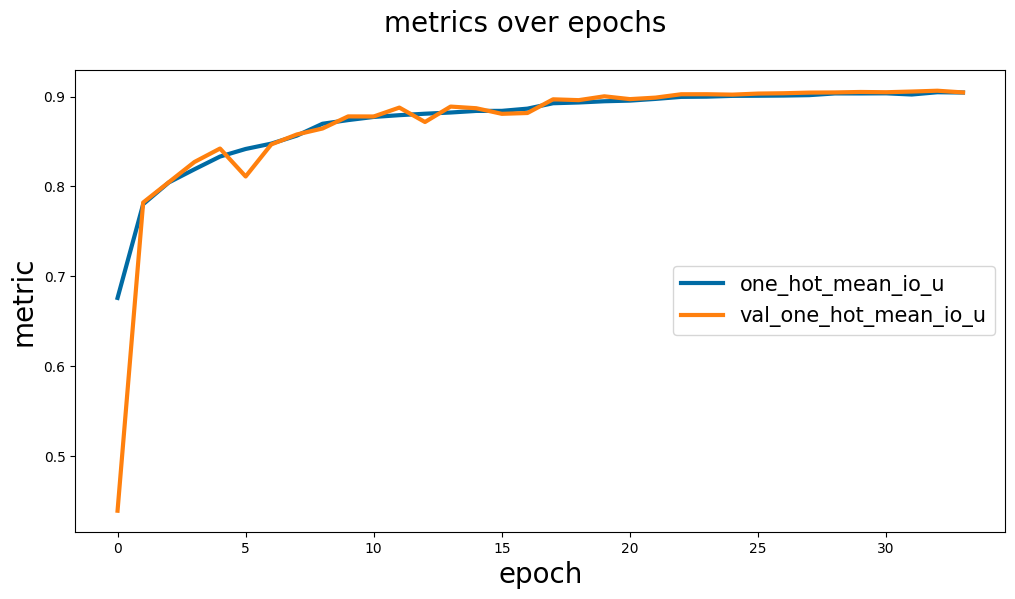

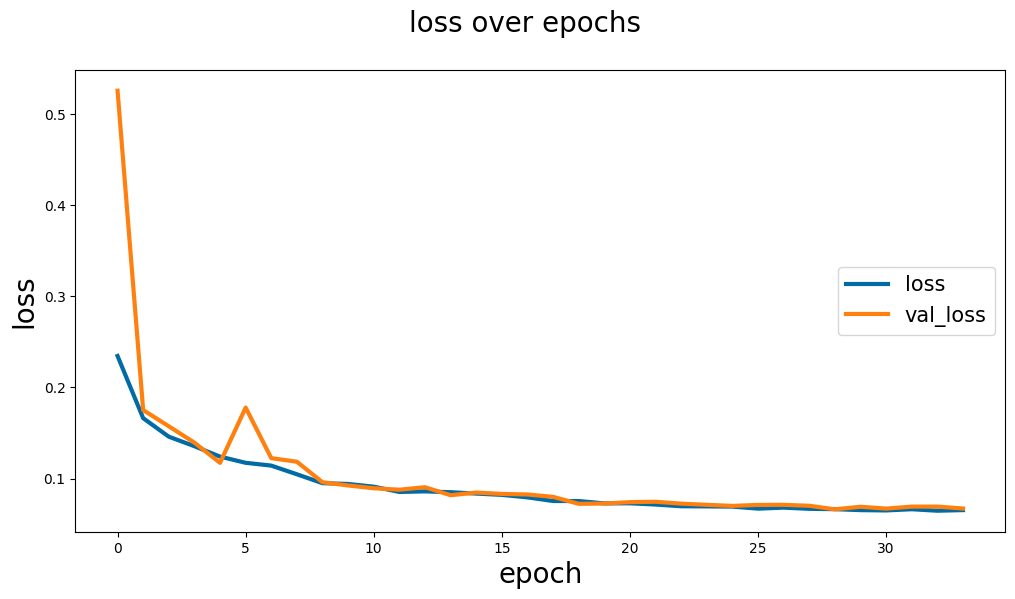

In [23]:
plot_history(resunet_pp_history1)

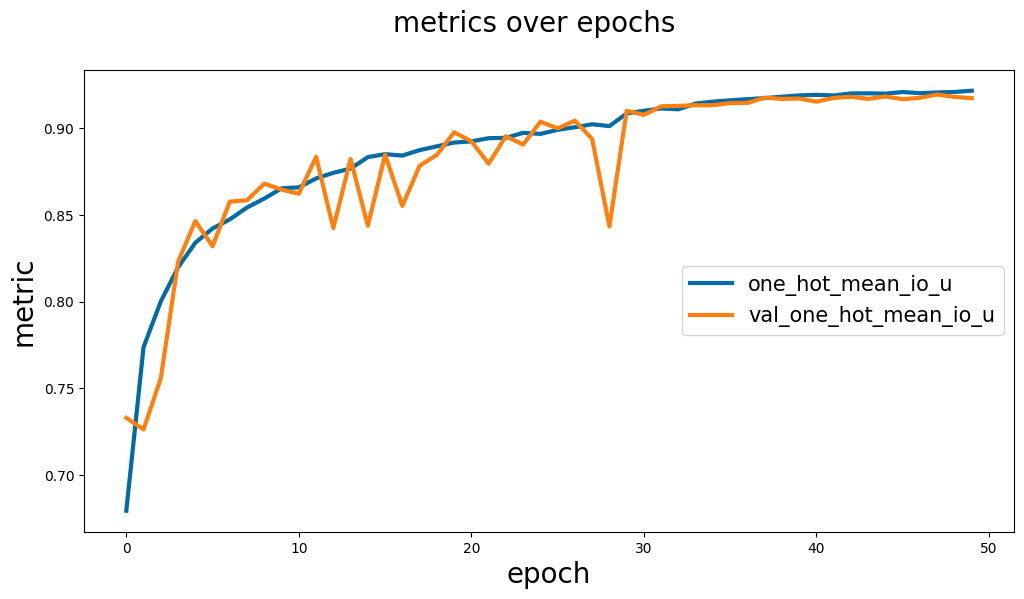

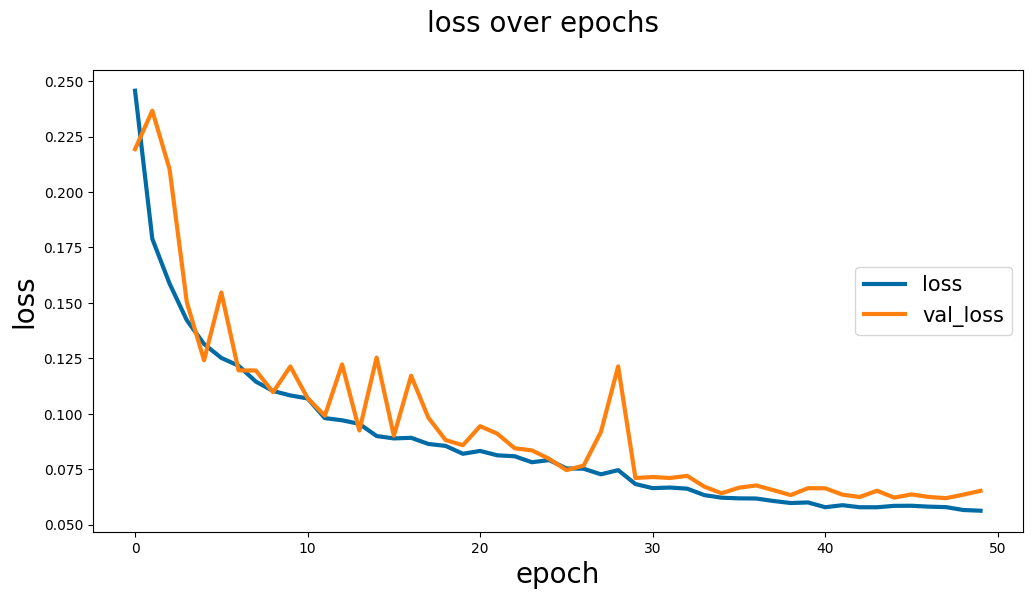

In [24]:
plot_history(resunet_pp_history2)

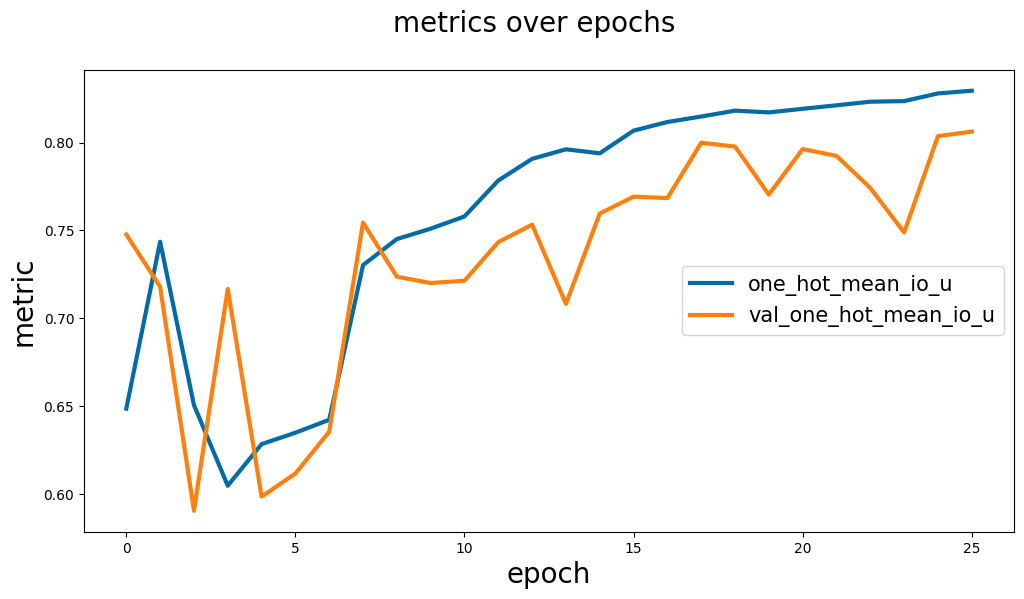

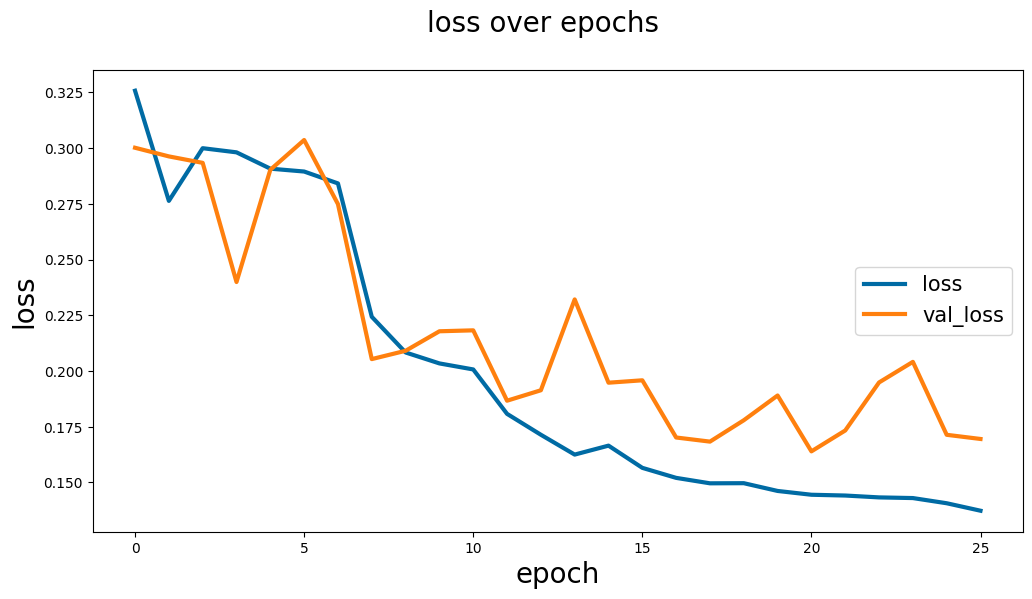

In [25]:
plot_history(resunet_pp_history3)

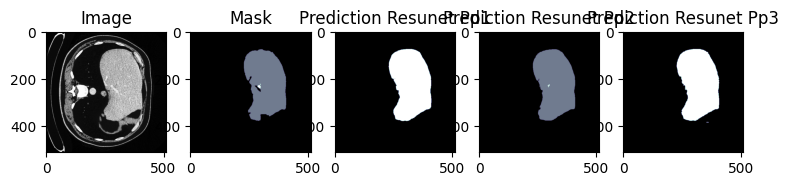

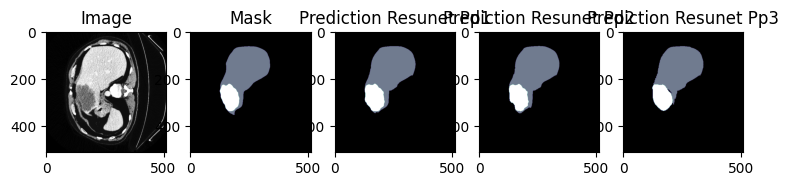

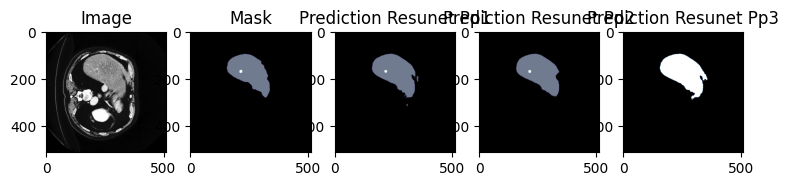

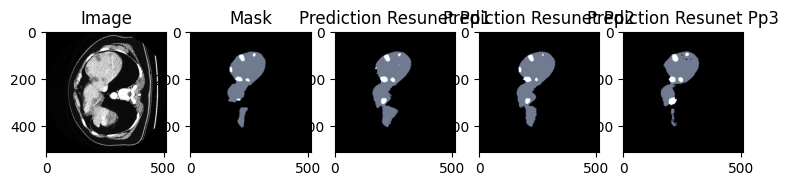

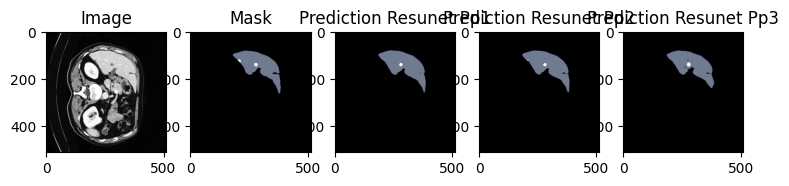

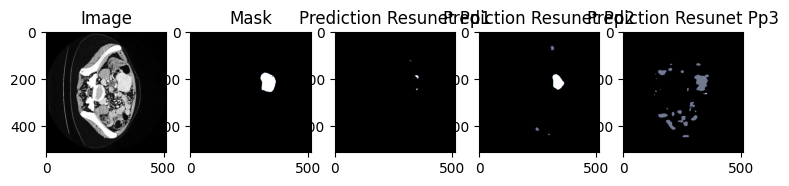

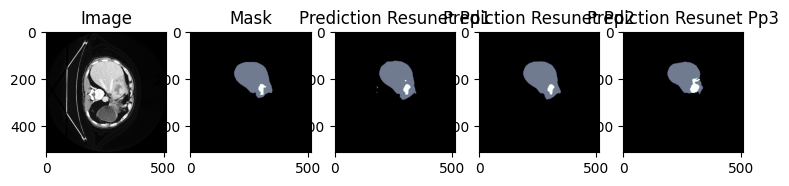

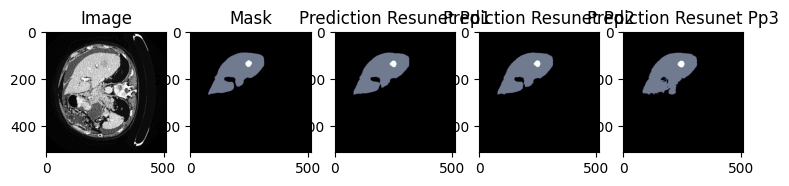

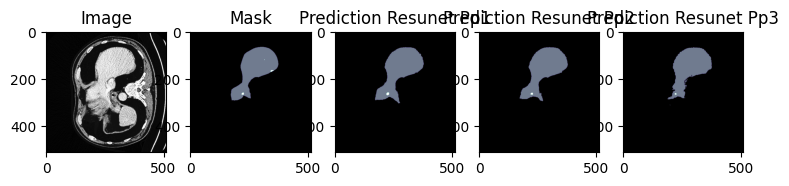

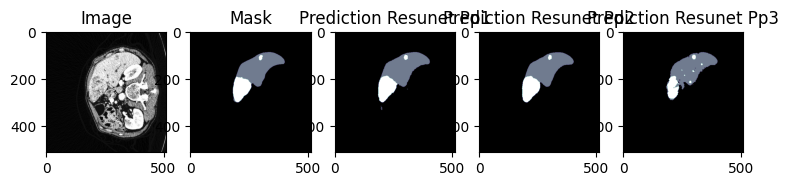

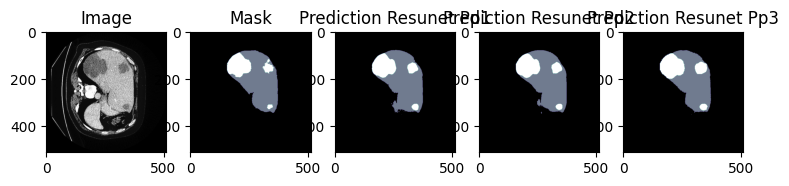

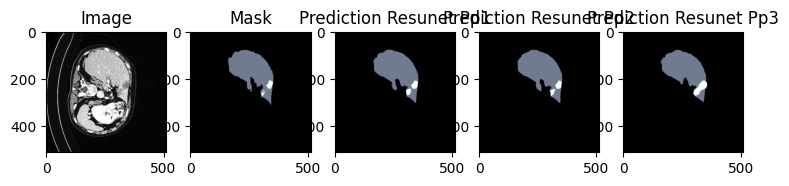

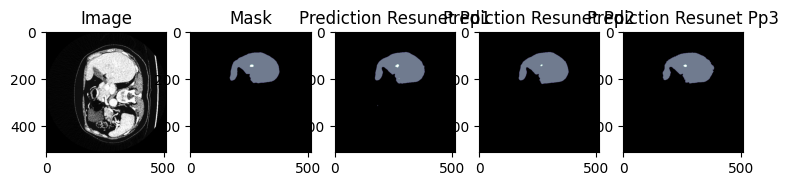

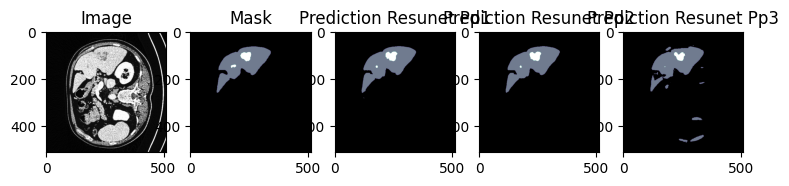

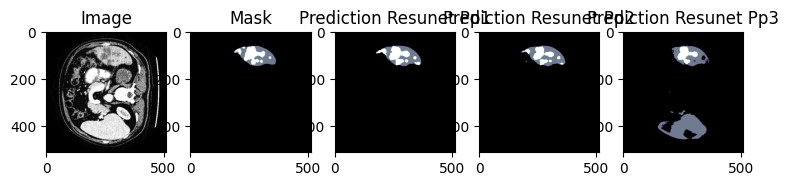

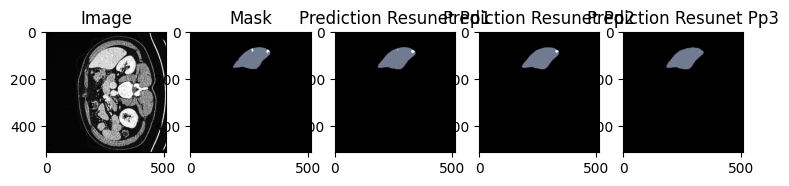

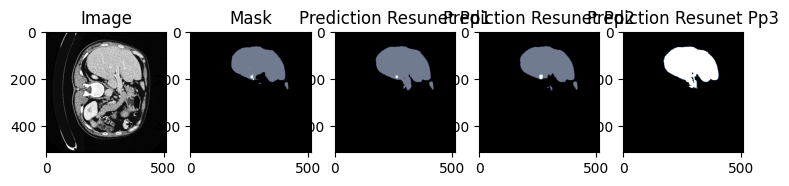

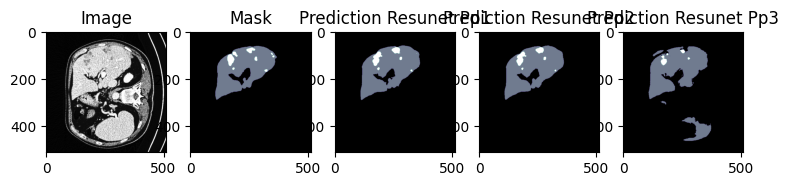

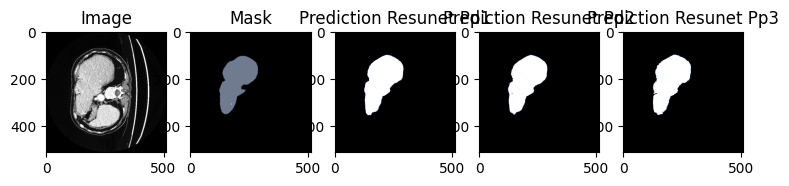

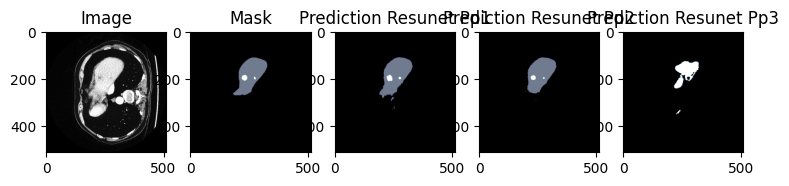

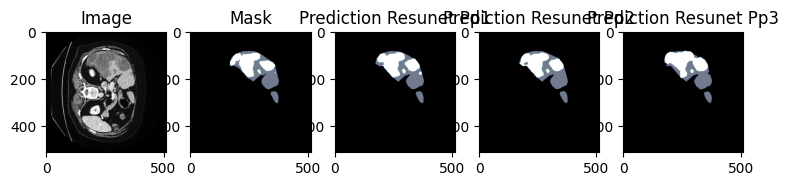

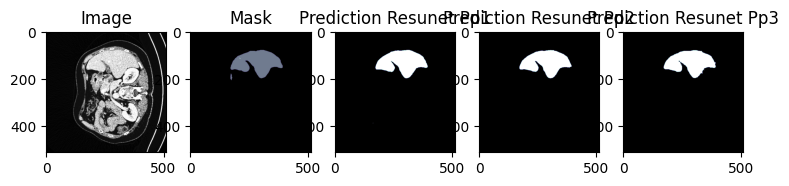

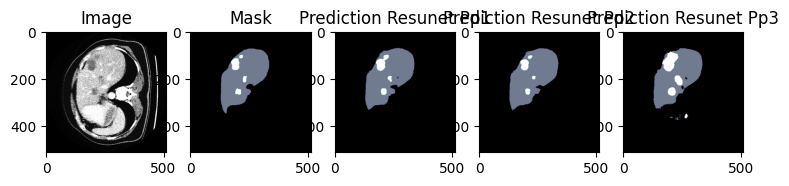

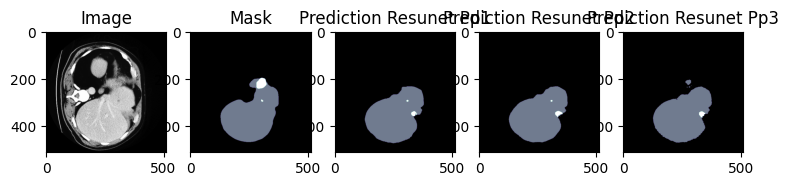

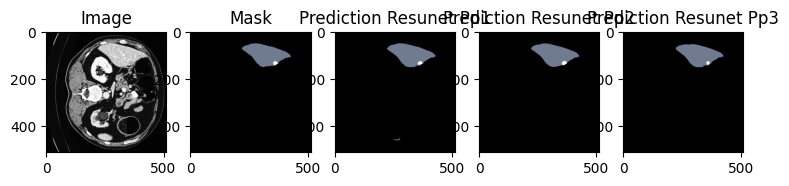

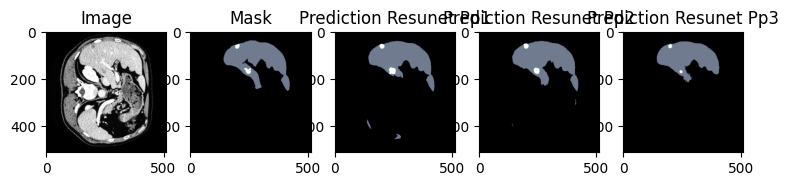

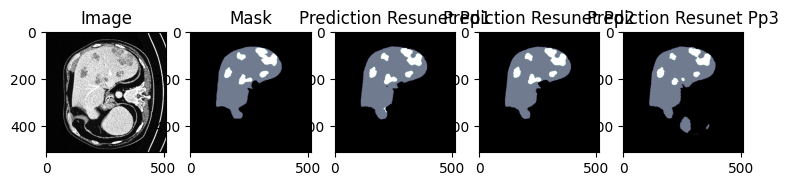

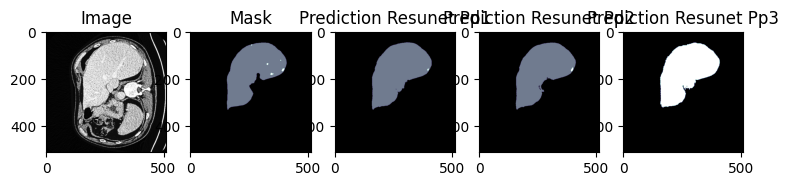

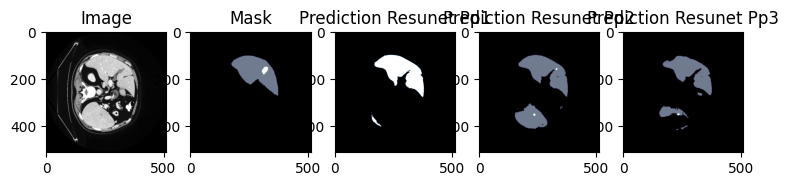

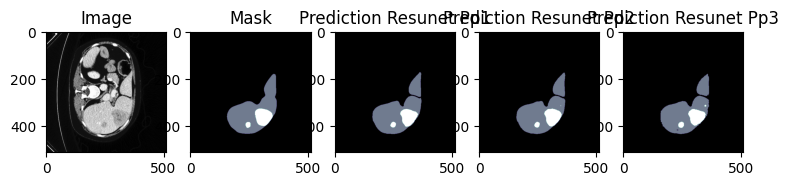

In [28]:
import random

# random.seed(42)

l = random.sample(range(712), 30)


for i in l:
    img = test_x[i]
    image = read_image(img)

    image = np.expand_dims(image,axis=0)

    prediction_resunet_pp1 = resunet_plus_plus_1.predict(image).squeeze()
    prediction_resunet_pp1 = np.argmax(prediction_resunet_pp1, axis=-1).astype(np.int32)

    prediction_resunet_pp2 = resunet_plus_plus_2.predict(image).squeeze()
    prediction_resunet_pp2 = np.argmax(prediction_resunet_pp2, axis=-1).astype(np.int32)

    prediction_resunet_pp3 = resunet_plus_plus_3.predict(image).squeeze()
    prediction_resunet_pp3 = np.argmax(prediction_resunet_pp3, axis=-1).astype(np.int32)

    visualize(image = read_image(test_x[i]), mask = read_mask(test_y[i]), 
    prediction_resunet_pp1 = prediction_resunet_pp1,
    prediction_resunet_pp2 = prediction_resunet_pp2, 
    prediction_resunet_pp3 = prediction_resunet_pp3
    )

In [31]:
from tensorflow.keras.utils import to_categorical 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

1. TP are on diagonal
2. FP are column-wise sums
3. FN are row-wise sums

In [32]:
def calculate_mean_precision_recall(model):
    precisions = []
    recalls = []
    for i in range(len(test_x)):
        mask = read_mask(test_y[i])

        image = read_image(test_x[i])
        image = np.expand_dims(image, axis=0)

        prediction = model.predict(image).squeeze()
        prediction = np.argmax(prediction, axis=-1).astype(np.int32)

        prediction_flattened = prediction.flatten()

        mask_flattened = mask.flatten()

        cf_matrix = confusion_matrix(mask_flattened, prediction_flattened, normalize='true')

        TP = np.diag(cf_matrix)

        precision = TP / (np.sum(cf_matrix, axis=0) + 1e-15)
        recall = TP / (np.sum(cf_matrix, axis=1) + 1e-15)

        precisions.append(precision)
        recalls.append(recall)

    return np.vstack(precisions).mean(axis=0), np.vstack(recalls).mean(axis=0)

In [33]:
mean_precision, mean_recall = calculate_mean_precision_recall(resunet_plus_plus_1)
print(mean_precision, mean_recall)

[0.95864427 0.86451084 0.88882002] [0.99560837 0.95246772 0.78394128]


In [34]:
mean_precision, mean_recall = calculate_mean_precision_recall(resunet_plus_plus_2)
print(mean_precision, mean_recall)

[0.94964062 0.84623988 0.89849604] [0.99677998 0.94765834 0.7616457 ]


In [35]:
mean_precision, mean_recall = calculate_mean_precision_recall(resunet_plus_plus_3)
print(mean_precision, mean_recall)

[0.83770053 0.78099795 0.74578927] [0.99162367 0.87385489 0.54540457]
